<h1><b><center>CLASIFICACIÓN DE NORMALIDAD EN TEJIDO DE MAMAS A PARTIR DE IMÁGENES DIGITALES DE RAYOS X</center></h1> 

|<h2><font color='white'>-----------------------</font><b>DIEGO FERNANDO VELASCO GIRALDO||
|---|---|
|||
|||
| <left><font size="4">Estudiante de Maestría en Ingeniería con Énfasis en Ingeniería Electrónica</font> | <center><img src="https://drive.google.com/uc?id=1CtdK5Litx2pQmTGD3U2Qs0MxIVs_nB8H" width="55" height="80" /> |
|||    
| <left><font size="4">Grupo de Investigación Percepción y Sistemas Inteligentes - Univalle</font> | <center><img src="https://drive.google.com/uc?id=1qEQd1k3SOIeLx-X0OSYQ0DosajsIy9Vc" width="165" height="70" /> |
|||
| <left><i><font size="4">Correo Electrónico: diego.fernando.velasco@correounivalle.edu.co</font></i> | <center><i><font size="4">Celular: 3234777477</font></i> |
|||
    
<center><h4><i>Proyecto de Grado - Modalidad: Profundización - Universidad del Valle - Director: Humberto Loaiza, Ph.D.</i></h4>
<br>

##<b> Importación de librerías necesarias: </b>

In [ ]:
import os
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime

import pandas as pd
import cv2
import glob
import random
import shutil

# Librerias para constuir la arquitectura U-Net
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##<b> Montaje de unidad Google Drive en el entorno de ejecución: </b>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Implementación Proyecto Grado Maestría

Mounted at /content/drive
/content/drive/MyDrive/Implementación Proyecto Grado Maestría


##<b> Verificación presencia de GPU: </b>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
#gpu_info = !nvidia-smi
#gpu_info = '\n'.join(gpu_info)
#if gpu_info.find('failed') >= 0:
#  print('Not connected to a GPU')
#else:
#  print(gpu_info)

##<b> Carga de dataframe descriptivo del mini-MIAS dataset: </b>

In [ ]:
dataPath = "all-mias"
textFile = os.path.join(dataPath,"miasInfo.txt")
mias_df = pd.read_csv(textFile, sep=" ", header=0)
mias_df.head()

#OJO: metadatos de Kaggle están mal. Marcan la mdb212 como anormal (mdb212 G CALC B 687 882 3) y es normal. Puede haber otras mal etiquetadas. OJO
#Usaré los metadatos de: http://peipa.essex.ac.uk/info/mias.html

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0


In [ ]:
values = {"SEVERITY": 'N', "X": 0, "Y": 0, "RADIUS": 0}
mias_df = mias_df.fillna(value=values)
#mias_df.head()

In [ ]:
mias_df.X = mias_df.X.astype(int)
mias_df.Y = mias_df.Y.astype(int)
mias_df.RADIUS = mias_df.RADIUS.astype(int)
mias_df.head()

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535,425,197
1,mdb002,G,CIRC,B,522,280,69
2,mdb003,D,NORM,N,0,0,0
3,mdb004,D,NORM,N,0,0,0
4,mdb005,F,CIRC,B,477,133,30


In [ ]:
#Split by class:
benignClass = mias_df[mias_df.SEVERITY=='B']
print("benignClass before balance shape: ", benignClass.shape)

malignantClass = mias_df[mias_df.SEVERITY=='M']
print("malignantClass before balance shape: ", malignantClass.shape)

normalClass = mias_df[mias_df.SEVERITY=='N']
print("normalClass before balance shape: ", normalClass.shape)

benignClass before balance shape:  (67, 7)
malignantClass before balance shape:  (54, 7)
normalClass before balance shape:  (209, 7)


In [ ]:
mias_df_2 = pd.concat([benignClass, malignantClass, normalClass]) 
print(mias_df_2)

     REFNUM BG CLASS SEVERITY    X    Y  RADIUS
0    mdb001  G  CIRC        B  535  425     197
1    mdb002  G  CIRC        B  522  280      69
4    mdb005  F  CIRC        B  477  133      30
5    mdb005  F  CIRC        B  500  168      26
10   mdb010  F  CIRC        B  525  425      33
..      ... ..   ...      ...  ...  ...     ...
325  mdb318  D  NORM        N    0    0       0
326  mdb319  D  NORM        N    0    0       0
327  mdb320  D  NORM        N    0    0       0
328  mdb321  D  NORM        N    0    0       0
329  mdb322  D  NORM        N    0    0       0

[330 rows x 7 columns]


In [ ]:
#files = glob.glob(dataPath+'/all-miasPythonProcessed/*.png')
#files = glob.glob(dataPath+'/all-mias_mat_proc_eq/*.png')

#if os.path.isdir(dataPath+'/all-miasPyProc-new') is False:
#  os.mkdir(dataPath+'/all-miasPyProc-new')
#  for myFile in files:
#      basename = os.path.basename(myFile)  # e.g. MyPhoto.jpg
#      name = os.path.splitext(basename)[0]  # e.g. MyPhoto
#      name = name[:6]
#      shutil.copy(myFile, dataPath+'/all-miasPyProc-new/'+name+'_proc.png')

In [ ]:
if os.path.isdir(dataPath+'/U-Net_breast_seg_h_eq(best)/') is False:
  os.makedirs(dataPath+'/U-Net_breast_seg_h_eq(best)/train/images')
  os.makedirs(dataPath+'/U-Net_breast_seg_h_eq(best)/train/masks')


  orig_imgs_path = (dataPath+'/allmias_PNG_mat_eq/')
  orig_msks_path = (dataPath+'/roi_breast_polygons_masks/')

  images = glob.glob(orig_imgs_path + '*.png')
  #train_imgs = random.sample(imgs, 33) 

  masks = glob.glob(orig_msks_path + '*.png')
  #test_imgs = random.sample(msks, 33)

  for image, mask in zip(images, masks):
      shutil.copy(image, dataPath+'/U-Net_breast_seg_h_eq(best)/train/images')   
      shutil.copy(mask, dataPath+'/U-Net_breast_seg_h_eq(best)/train/masks')  

In [ ]:
if os.path.isdir(dataPath+'/U-Net_breast_seg_h_eq(best)/test/') is False:
  os.makedirs(dataPath+'/U-Net_breast_seg_h_eq(best)/test/images', exist_ok=True)
  os.makedirs(dataPath+'/U-Net_breast_seg_h_eq(best)/test/masks', exist_ok=True)

  train_imgs = glob.glob(dataPath+'/U-Net_breast_seg_h_eq(best)/train/images/*.png')

  test_imgs = random.sample(train_imgs, 48) # Aprox. (65: 20%) (48: 15%)
  test_msks=[]
  
  for test_img in test_imgs:
      index_n = test_img.find('output')
      index_n_2 = test_img.find('images/') 
      test_msk = test_img[:index_n] + 'roi_breast' + test_img[index_n+6:]
      test_msk_2 = test_msk[:index_n_2] + 'masks/' + test_msk[index_n_2+7:]
      test_msks.append(test_msk_2) 

  print(test_imgs)
  print(test_msks) 

  for test_image, test_mask in zip(test_imgs, test_msks):
      shutil.move(test_image, dataPath+'/U-Net_breast_seg_h_eq(best)/test/images')   
      shutil.move(test_mask, dataPath+'/U-Net_breast_seg_h_eq(best)/test/masks') 

['all-mias/U-Net_breast_seg_h_eq(best)/train/images/mdb213_output.png', 'all-mias/U-Net_breast_seg_h_eq(best)/train/images/mdb246_output.png', 'all-mias/U-Net_breast_seg_h_eq(best)/train/images/mdb135_output.png', 'all-mias/U-Net_breast_seg_h_eq(best)/train/images/mdb028_output.png', 'all-mias/U-Net_breast_seg_h_eq(best)/train/images/mdb287_output.png', 'all-mias/U-Net_breast_seg_h_eq(best)/train/images/mdb125_output.png', 'all-mias/U-Net_breast_seg_h_eq(best)/train/images/mdb273_output.png', 'all-mias/U-Net_breast_seg_h_eq(best)/train/images/mdb090_output.png', 'all-mias/U-Net_breast_seg_h_eq(best)/train/images/mdb119_output.png', 'all-mias/U-Net_breast_seg_h_eq(best)/train/images/mdb168_output.png', 'all-mias/U-Net_breast_seg_h_eq(best)/train/images/mdb118_output.png', 'all-mias/U-Net_breast_seg_h_eq(best)/train/images/mdb219_output.png', 'all-mias/U-Net_breast_seg_h_eq(best)/train/images/mdb229_output.png', 'all-mias/U-Net_breast_seg_h_eq(best)/train/images/mdb178_output.png', 'all-

Creo los arreglos de imágenes redimensionadas que van a ir a U-Net:

In [ ]:
imgs_train_path = dataPath+'/U-Net_breast_seg_h_eq(best)/train/images/'
msks_train_path = dataPath+'/U-Net_breast_seg_h_eq(best)/train/masks/'
imgs_test_path = dataPath+'/U-Net_breast_seg_h_eq(best)/test/images/'
msks_test_path = dataPath+'/U-Net_breast_seg_h_eq(best)/test/masks/'

# Listas con los archivos dentro de cada carpeta:
imgs_train = glob.glob(imgs_train_path+'*.png')
imgs_train = sorted(imgs_train) 
msks_train = glob.glob(msks_train_path+'*.png')
msks_train = sorted(msks_train) 
imgs_test = glob.glob(imgs_test_path+'*.png')
imgs_test = sorted(imgs_test) 
msks_test = glob.glob(msks_test_path+'*.png')
msks_test = sorted(msks_test) 

# Listas para guardar cada elemento del dataset:
Xtrain = [] 
Ytrain = []
Xtest = []
Ytest = []

#Listas para guardar nombres correspondientes:
Xtrain_names = []
Ytrain_names = []
Xtest_names = []
Ytest_names = []

width_shape, height_shape = 128, 128 #Tamaño imágenes de entrada
dim = (width_shape, height_shape)

# Recorremos la carpeta train
for image, msk in tqdm(zip(imgs_train, msks_train)):
    img = cv2.imread(image, 1)  
    #img = resize(img, (height_shape, width_shape), mode='constant', preserve_range=True)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    # Agrego cada imagen a la lista Xtrain:
    Xtrain.append(img)
    # Agrego cada nombre a la lista Xtrain_names:
    basename = os.path.basename(image)  # e.g. MyPhoto.jpg
    name = os.path.splitext(basename)[0]  # e.g. MyPhoto 
    Xtrain_names.append(name)
    # Leo cada una de las mascaras binarias y las redimensiono:
    mask = cv2.imread(msk, 0) 
    #mask = resize(mask, (height_shape, width_shape), mode='constant', preserve_range=True)
    mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
    mask = np.expand_dims(mask, axis=-1)  
    # Agrego cada máscara a la lista Ytrain:
    Ytrain.append(mask)
    # Agrego cada nombre a la lista Xtrain_names:
    basename = os.path.basename(msk)  # e.g. MyPhoto.jpg
    name = os.path.splitext(basename)[0]  # e.g. MyPhoto 
    Ytrain_names.append(name)

#Xtrain_names = sorted(Xtest_names)
#Ytrain_names = sorted(Xtest_names)

# Recorremos la carpeta test
for image, msk in tqdm(zip(imgs_test, msks_test)):
    img = cv2.imread(image, 1)   
    #img = resize(img, (height_shape, width_shape), mode='constant', preserve_range=True)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    # Agrego cada imagen a la lista Xtest:
    Xtest.append(img)
    # Agrego cada nombre a la lista Xtrain_names:
    basename = os.path.basename(image)  # e.g. MyPhoto.jpg
    name = os.path.splitext(basename)[0]  # e.g. MyPhoto 
    Xtest_names.append(name)
    # Leo cada una de las mascaras binarias y las redimensiono:
    mask = cv2.imread(msk, 0) 
    #mask = resize(mask, (height_shape, width_shape), mode='constant', preserve_range=True)
    mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
    mask = np.expand_dims(mask, axis=-1)  
    # Agrego cada máscara a la lista Ytest
    Ytest.append(mask)
    # Agrego cada nombre a la lista Xtrain_names:
    basename = os.path.basename(msk)  # e.g. MyPhoto.jpg
    name = os.path.splitext(basename)[0]  # e.g. MyPhoto 
    Ytest_names.append(name)
   
X_train = np.asarray(Xtrain,dtype=np.uint8)
print('\nXtrain:',X_train.shape)

Y_train = np.asarray(Ytrain,dtype=bool)
print('Ytrain:',Y_train.shape)

X_test = np.asarray(Xtest,dtype=np.uint8)
print('Xtest:',X_test.shape)

Y_test = np.asarray(Ytest,dtype=bool)
print('Ytest:',Y_test.shape)

274it [00:05, 51.98it/s]
48it [00:00, 53.97it/s]


Xtrain: (274, 128, 128, 3)
Ytrain: (274, 128, 128, 1)
Xtest: (48, 128, 128, 3)
Ytest: (48, 128, 128, 1)


mdb004_output


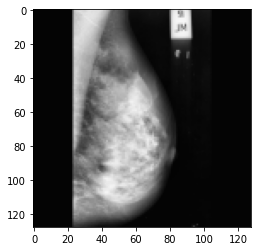

mdb004_roi_breast


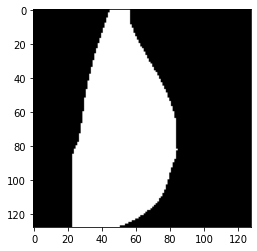

(128, 128, 3)
(128, 128)
(128, 128, 1)
(128, 128)


In [ ]:
index_img = 3
# Imagen y su mascara asociada:
print(Xtrain_names[index_img])
plt.imshow(X_train[index_img])
plt.show()
#plt.imshow(Y_train[0][:,:,0], cmap='gray')
print(Ytrain_names[index_img])
plt.imshow(np.squeeze(Y_train[index_img]), cmap='gray')
plt.show()

print(X_train[index_img].shape)
print(X_train[index_img][:,:,1].shape)
print(Y_train[index_img].shape)
print(np.squeeze(Y_train[index_img]).shape)

## Modelo U-Net:

In [ ]:
# Entrada al modelo:
Image_input = Input((height_shape, width_shape, 3))
Image_in = Lambda(lambda x: x / 255)(Image_input)

#contracting path
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(Image_in)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
maxp1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(maxp1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
maxp2 = MaxPooling2D((2, 2))(conv2)
 
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(maxp2)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
maxp3 = MaxPooling2D((2, 2))(conv3)
 
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(maxp3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
maxp4 = MaxPooling2D(pool_size=(2, 2))(conv4)
 
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(maxp4)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

#expansive path
up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
up6 = concatenate([up6, conv4])
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
 
up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
up7 = concatenate([up7, conv3])
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
 
up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
up8 = concatenate([up8, conv2])
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
 
up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
up9 = concatenate([up9, conv1], axis=3)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
 
outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
 
model = Model(inputs=[Image_input], outputs=[outputs])

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


#learning_rate = 0.01
#from tensorflow.keras.optimizers import SGD
#sgd = SGD(lr=learning_rate, nesterov=True) #decay=learning_rate, #momentum=0.3, nesterov=True)
#model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

#model.summary()

## Entrenamiento:

In [ ]:
batch_size = 20 #20 para que sean 8 pasos por epoch porque son 257 imágenes de train = 257/20 = 12.85
epochs = 120 #60 

checkpoint_filepath = dataPath+'/U-Net_breast_seg_h_eq(best)/checkpoints/'    

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


history_U_Net = model.fit(X_train, Y_train, validation_split=0.1, batch_size=batch_size, epochs=epochs, callbacks=model_checkpoint_callback) #[tensorboard_callback]

Epoch 1/120
13/13 [==============================] - 7s 467ms/step - loss: 0.6660 - accuracy: 0.6731 - val_loss: 0.6096 - val_accuracy: 0.7863
Epoch 2/120
13/13 [==============================] - 5s 368ms/step - loss: 0.6129 - accuracy: 0.8042 - val_loss: 0.5451 - val_accuracy: 0.9017
Epoch 3/120
13/13 [==============================] - 5s 373ms/step - loss: 0.5052 - accuracy: 0.8882 - val_loss: 0.2735 - val_accuracy: 0.9084
Epoch 4/120
13/13 [==============================] - 6s 463ms/step - loss: 0.2228 - accuracy: 0.9172 - val_loss: 0.1785 - val_accuracy: 0.9308
Epoch 5/120
13/13 [==============================] - 5s 368ms/step - loss: 0.1553 - accuracy: 0.9366 - val_loss: 0.1407 - val_accuracy: 0.9383
Epoch 6/120
13/13 [==============================] - 5s 365ms/step - loss: 0.1099 - accuracy: 0.9532 - val_loss: 0.0953 - val_accuracy: 0.9602
Epoch 7/120
13/13 [==============================] - 6s 443ms/step - loss: 0.0965 - accuracy: 0.9603 - val_loss: 0.0950 - val_accuracy: 0.9601

In [ ]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Guardo el modelo:

In [ ]:
#model.save(dataPath+'/U-Net_breast_seg_h_eq(best)/checkpoints/min_val_loss_breast_seg_eq_02_58.h5')  # creates a HDF5 file 'my_model.h5'

#del model  # deletes the existing model
dataPath = 'all-mias'

# returns a compiled model, identical to the previous one
from keras.models import load_model
#model = load_model(dataPath+'/U-Net_breast_seg_h_eq(best)/checkpoints/min_val_loss_breast_seg_eq.h5')
#print(model.summary())

NameError: ignored

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


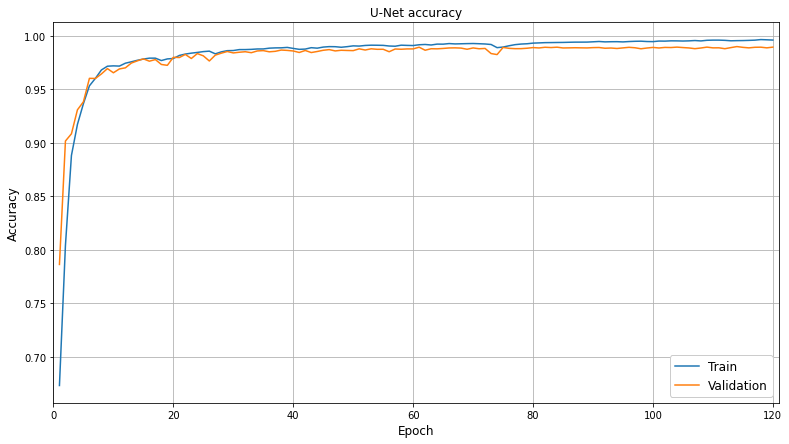

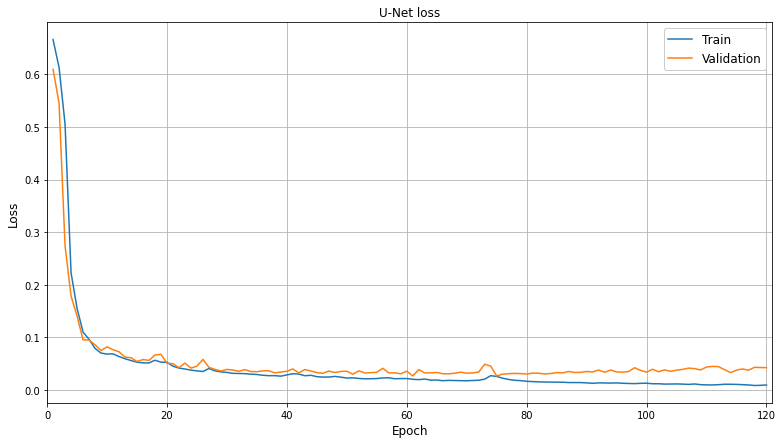

In [ ]:
from keras.callbacks import History
#epochs = 5

# list all data in history
print(history_U_Net.history.keys())
#print(history.history['accuracy'])

# summarize history for accuracy
plt.figure(figsize=(13, 7))
plt.plot(np.arange(1, epochs+1, 1), history_U_Net.history['accuracy'])
plt.plot(np.arange(1, epochs+1, 1), history_U_Net.history['val_accuracy'])
#plt.xticks(np.arange(1, epochs+1, 1), list(range(1, epochs+1)))
plt.xlim([0, epochs+1])
plt.title('U-Net accuracy', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='lower right', framealpha=1, fontsize=12)
plt.grid()
plt.show()

# summarize history for loss
plt.figure(figsize=(13, 7))
plt.plot(np.arange(1, epochs+1, 1), history_U_Net.history['loss'])
plt.plot(np.arange(1, epochs+1, 1), history_U_Net.history['val_loss'])
#plt.xticks(np.arange(1, epochs+1, 1), list(range(1, epochs+1)))
plt.xlim([0, epochs+1])
plt.title('U-Net loss', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right', framealpha=1, fontsize=12)#, fancybox=True)
plt.grid()
plt.show()

# Métricas de rendimiento

In [ ]:
preds = model.predict(X_test)

2/2 [==============================] - 5s 2s/step


## Prueba con imagen de test:

In [ ]:
image_position = 13

print('Mamografía:')
print(Xtest_names[image_position])
plt.imshow(X_test[image_position], cmap='gray')
plt.show()

print('\nMáscara ground truth:')
print(Ytest_names[image_position])
test_masks = Y_test
plt.imshow(np.squeeze(test_masks[image_position]), cmap='gray')
plt.show()

print('\nMáscara detectada:')
preds = model.predict(X_test)
plt.imshow(np.squeeze(preds[image_position]), cmap='gray')
plt.show()

print('\nAumento de tamaño a original:')
dim = (1024, 1024)
resized = cv2.resize(preds[image_position], dim, interpolation = cv2.INTER_AREA)
resized = cv2.normalize(resized, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
resized = resized.astype(np.uint8)
print(resized.shape)
#print(np.unique(resized))
thresh = 90
resized = cv2.threshold(resized, thresh, 255, cv2.THRESH_BINARY)[1]
plt.imshow(resized, cmap='gray')
plt.show()

In [ ]:
#Si la carpeta no está creada:
if os.path.isdir(dataPath+'/roi_breast_eq_U_Net_msks_bin/') is False:
  os.mkdir(dataPath+'/roi_breast_eq_U_Net_msks_bin/') 
  U_Net_masks = (dataPath+'/roi_breast_eq_U_Net_msks_bin/')
  
  imgs_to_seg_path = dataPath+'/allmias_PNG_mat_eq/'
  imgs_to_seg = glob.glob(imgs_to_seg_path+'*.png')
  imgs_to_seg = sorted(imgs_to_seg) 

  images = []
  names = []

  dim = 128, 128

  for img_to_seg in imgs_to_seg:
      img = cv2.imread(img_to_seg, 1)
      img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
      basename = os.path.basename(img_to_seg)  # e.g. MyPhoto.jpg
      name = os.path.splitext(basename)[0]  # e.g. MyPhoto
      images.append(img)
      names.append(name[:6]+'_roi_breast')

  images = np.asarray(images,dtype=np.uint8)
  preds = model.predict(images)
  
  dim = 1024, 1024

  for pred_img, name in zip(preds, names):
      pred_img = cv2.normalize(pred_img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
      pred_img = cv2.resize(pred_img, dim, interpolation = cv2.INTER_AREA)
      thresh = 90
      pred_img = cv2.threshold(pred_img, thresh, 255, cv2.THRESH_BINARY)[1]
      cv2.imwrite((U_Net_masks +  name + '.png'), pred_img, [int(cv2.IMWRITE_PNG_COMPRESSION),0])
      
#imgs_train = sorted(imgs_train) 

In [ ]:
#Entrenar densenet
#Implementar NN y SV adicionando LBP como característica
#Mejorar ROC
#Documentar todo

In [ ]:
masked_image = cv2.bitwise_and(image,mask)
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(masked_image, cmap='gray', vmin=0, vmax=255)
ax.set_title("mask for "+image_name)
ax.axis('off')
plt.tight_layout()
plt.show()